<a href="https://colab.research.google.com/github/sanggusti/bangkit-2024-h2-ML-materials/blob/feat%2Filt5/ILT5-advanced-tensorflow/Demo_ILT_5_Sailing_through_Time_A_Navigator's_Guide_to_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series

This tutorial demonstrates time series forecasting using TensorFlow on sunspots dataset.

## Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow.keras import layers, models, optimizers

## Prepare the dataset for training

In [ ]:
!wget --no-check-certificate \
    https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv \
    -O /tmp/sunspots.csv

--2024-10-28 14:29:50--  https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/Simulation/machine_learning/sunspots.csv [following]
--2024-10-28 14:29:51--  https://raw.githubusercontent.com/dicodingacademy/assets/main/Simulation/machine_learning/sunspots.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68195 (67K) [text/plain]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  66.60K  --.-KB/s    in 0.01s   

2024-10-28 14:29:51 (6.72 MB/s) - ‘/tmp/su

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

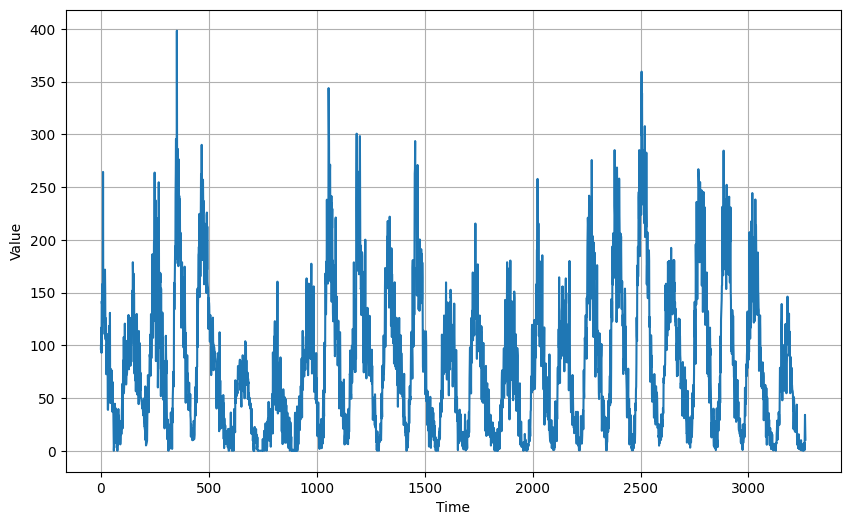

In [ ]:
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
# Normalization
min=np.min(series)
max=np.max(series)
series -= min
series /= max
time=np.array(time_step)

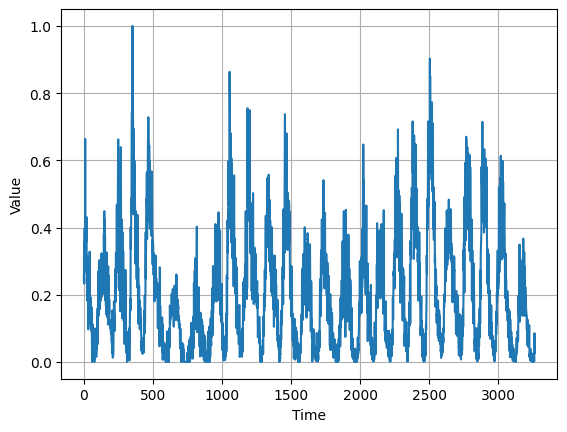

In [ ]:
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)



In [ ]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
tset = list(train_set)

In [ ]:
len(tset[0][0][0])

60

In [ ]:
validation_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

## Create the model

In [ ]:
def create_model(window_size):
  model = models.Sequential([
    layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.RepeatVector(window_size),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.RepeatVector(window_size),
    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.RepeatVector(window_size),
    layers.Bidirectional(layers.LSTM(16, return_sequences=True)),
    layers.Dense(20, input_shape=[window_size], activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1)
  ])

  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))

  return model

In [ ]:
model = create_model(window_size)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, None, 60)            │             360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 256)                 │         193,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_4 (RepeatVector)       │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_5 (RepeatVector)       │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 60, 32)              │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 60, 20)              │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 60, 10)              │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 60, 1)               │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,713 (1.57 MB)

 Trainable params: 410,713 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

## Train & evaluate the model

In [ ]:
model.fit(train_set, epochs=100)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - loss: 0.0705
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 377ms/step - loss: 0.0711
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - loss: 0.0712
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 381ms/step - loss: 0.0722
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - loss: 0.0720
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - loss: 0.0722
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - loss: 0.0723
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - loss: 0.0705
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - loss: 0.0703
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - loss: 0.0702
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 434ms/step - loss: 0.0705
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 376ms/step - loss: 0.0701
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 396ms/step - loss: 0.0695
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 377ms/step - loss: 0.0693
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 386ms/step - loss: 0.0700
Epoch 16/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(validation_set))

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
7/7 ━━

In [ ]:
forecast = forecast[split_time-window_size:]

In [ ]:
results = np.array(forecast)[:, 0, 0]

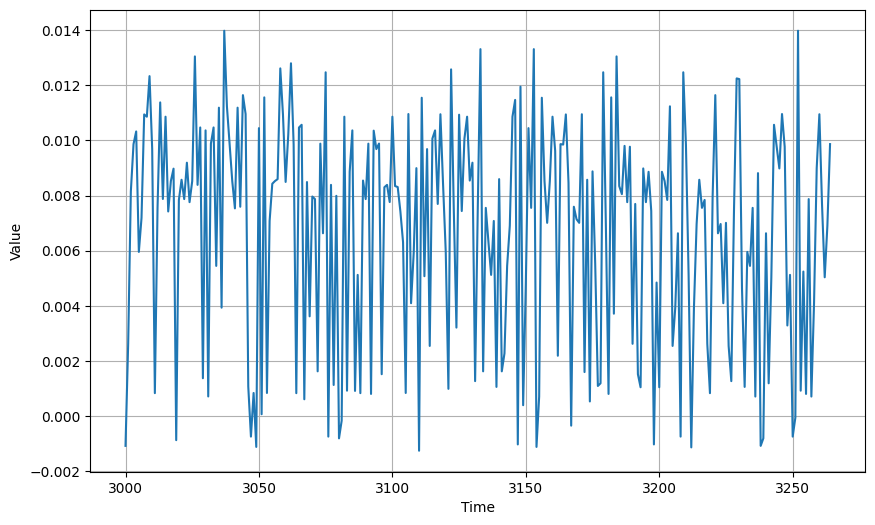

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, results)